In [1]:
import pandas as pd
import torch
import re

import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from torch import nn, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read + Preprocessing data

In [3]:
train_df = pd.read_csv("./dataset/train_health_content.csv")
test_df = pd.read_csv("./dataset/test_health_content.csv")

In [4]:
train_df

,id,title,text,rating,label
0,story_reviews_01118,Acupuncture May Help Ease Hot Flashes Tied to ...,"En Español\n\nMONDAY, April 25, 2011 (HealthDa...",3,0
1,story_reviews_01350,Aspirin May Cut Prostate Cancer Deaths,The findings were released at a news briefing ...,3,0
2,story_reviews_00749,Folic acid in pregnancy tied to lower autism risk,NEW YORK (Reuters Health) - Women who took ext...,4,0
3,story_reviews_01065,"Sleeptime Head-Cooling Cap Eases Insomnia, Stu...",By Jenifer Goodwin\n\nHealthDay Reporter\n\nTU...,4,0
4,news_reviews_00469,Chrono Therapeutics' Smoking Cessation Technol...,"CHICAGO, March 4, 2016 /PRNewswire/ -- Chrono ...",2,1
...,...,...,...,...,...
1337,story_reviews_00175,Immune-Focused Drug May Be New Weapon Against ...,"En Español\n\nMONDAY, Sept. 11, 2017 (HealthDa...",4,0
1338,story_reviews_00467,The Benefits of Intensive Cardiac Rehabilitati...,Despite considerable progress in prevention an...,3,0
1339,story_reviews_01529,Experimental flu treatment may help related virus,WASHINGTON (Reuters) - An experimental drug be...,3,0
1340,story_reviews_00892,Bypass Surgery Edges Stents For Heart Treatment,Bypass Surgery Edges Stents For Heart Treatmen...,4,0


In [5]:
train_df['input_text'] = train_df['title'] + " " + train_df['text']
test_df['input_text'] = test_df['title'] + " " + test_df['text']

In [6]:
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\W', ' ', text)   # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove digits
    text = text.strip()
    return text

In [7]:
train_df['input_text'] = train_df['input_text'].apply(clean_text)
test_df['input_text'] = test_df['input_text'].apply(clean_text)

# Build vocab

In [8]:
unique_train_labels = train_df['label'].unique()
class_to_int =  {label: i for i, label in enumerate(unique_train_labels)}
int_to_class = {i: label for label, i in class_to_int.items()}
train_tokens_to_indices_vocab = {"<pad>": 0, "<ukn>": 1}

idx = 2
for text, label in zip(train_df['input_text'], train_df['label']):
    tokenized_text = text.split(" ")
    for token in tokenized_text:
        if token not in train_tokens_to_indices_vocab:
            train_tokens_to_indices_vocab[token] = idx
            idx += 1

train_indices_to_tokens_vocab = {idx: token for token, idx in train_tokens_to_indices_vocab.items()}
print(len(train_tokens_to_indices_vocab))
print(list(train_tokens_to_indices_vocab.items())[:10])

26683
[('<pad>', 0), ('<ukn>', 1), ('acupuncture', 2), ('may', 3), ('help', 4), ('ease', 5), ('hot', 6), ('flashes', 7), ('tied', 8), ('to', 9)]


In [9]:
class InputTextDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe['input_text']
        self.y = dataframe['label']
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
def collate_fn_with_dict(token_vocab, label_vocab, unique_train_labels):
    def collate_fn(batch):
        inputs, labels = zip(*batch)
        
        tokens_indices = []
        labels_indices = []
        for tokens, label in zip(inputs, labels):
            if label not in unique_train_labels:
                continue
            label_indice = label_vocab[label]
            
            tokens_indices_aux = []
            
            for token in tokens:
                if token in token_vocab:
                    tokens_indices_aux.append(token_vocab[token])
                else:
                    tokens_indices_aux.append(token_vocab['<ukn>'])
            
            indices = torch.tensor(tokens_indices_aux, dtype=torch.long)
            
            tokens_indices.append(indices)
            labels_indices.append(label_indice)
            
        tokens_indices = pad_sequence(tokens_indices, batch_first=True, padding_value=token_vocab['<pad>'])
        labels_indices = torch.tensor(labels_indices)
        
        return tokens_indices, labels_indices
    return collate_fn

collate_fn = collate_fn_with_dict(train_tokens_to_indices_vocab, class_to_int, unique_train_labels)

In [11]:
train_dataset = InputTextDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

test_dataset = InputTextDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=3, collate_fn=collate_fn)

In [12]:
print(f"Train dataset size: {train_dataset.X.shape}")
print(f"Test dataset size: {test_dataset.X.shape}")

Train dataset size: (1342,)
Test dataset size: (448,)


In [14]:
def test(model, test_loader, criterior, test_fn=False):
    model.eval()
    running_loss = 0.0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterior(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss = running_loss / len(test_loader)
    
    if test_fn:
        print(classification_report(all_labels, all_preds, zero_division=0))
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

        print(f"Test Accuracy: {test_accuracy}")
        print(f"Test Precision: {test_precision}")
        print(f"Test Recall: {test_recall}")
        print(f"Test F1: {test_f1}")
    
    return test_loss

In [15]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    best_train_loss = float("inf")
    best_model = model
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dataloader)
        test_loss = test(model, test_dataloader, criterion)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs},"
              f"train_loss {train_loss:.4f},"
              f"test_loss {test_loss:.4f}")
        
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_model = model
            torch.save(best_model.state_dict(), "./models/best_LSTM_model.pt")
            print("Best model saved")
            
    print("Training finished")

# LSTM

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=train_tokens_to_indices_vocab['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Taking the output of the last time step
        output = self.fc(lstm_out)
        return output

In [17]:
train_losses = []
test_losses = []

vocab_size = len(train_tokens_to_indices_vocab)
embedding_dim = 64
hidden_dim = 128
output_dim = 2
num_epochs = 3
learning_rate = 0.001

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)

 33%|███▎      | 1/3 [00:52<01:45, 52.77s/it]

Epoch 1/3,train_loss 0.6442,test_loss 0.6313
Best model saved


 67%|██████▋   | 2/3 [01:45<00:52, 52.52s/it]

Epoch 2/3,train_loss 0.6338,test_loss 0.6413
Best model saved


100%|██████████| 3/3 [02:37<00:00, 52.39s/it]

Epoch 3/3,train_loss 0.6322,test_loss 0.6259
Best model saved
Training finished


In [19]:
test(model, test_dataloader, criterion, test_fn=True)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       299
           1       0.00      0.00      0.00       149

    accuracy                           0.67       448
   macro avg       0.33      0.50      0.40       448
weighted avg       0.45      0.67      0.53       448

Test Accuracy: 0.6674107142857143
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0


C:\Users\allex\miniconda3\envs\CV\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6258613101641337

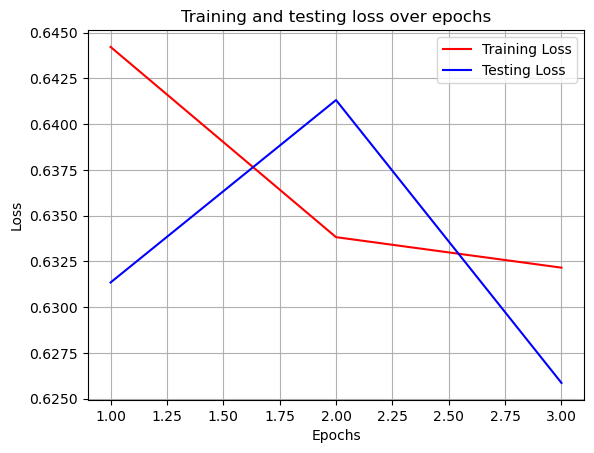

In [20]:
def plot_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='Red')
    plt.plot(epochs, test_losses, label='Testing Loss', color='Blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and testing loss over epochs")
    plt.legend()
    plt.grid()
    plt.show()


plot_losses(train_losses, test_losses)